# Movie Recomendation System
Recommendation systems offers several advantages in various industries, including personalized product or content suggestions, enhancing customer experience and user engagement. This technique enable businesses to target marketing effors more efectively, by analizing customer behavior and preferences. Furtheremore, sectors like retal, entertainment and finance leverage this approach for gaining competitive advantage and optimizing user interactions.

This repository presents the implementation of a movie recommendation system that leverages K-means clustering for movie classification and Collaborative Filtering for personalized user recommendations. This project is aimed at enhancing user engagement and driving insights into consumer preferences. The data used can be found at [Movie Lens Dataset](https://www.kaggle.com/datasets/aigamer/movie-lens-dataset?select=tags.csv).

The objectives of this project are:
- Gain valuable insights into user preferences.
- Generate a data set with the most valuable information to classify movies according to their characteristics.
- Make personalized movie recommendations based on the interests of each user.

The repository is organized as follows:
1. Exploratory Data Analysis (EDA).
2. Model implementation.
3. Recomendation examples.

## 1. Exploratory Data Analysis (EDA)
First, we estar by loading the required libraries and reading the movies data:

In [1]:
# load libraries
import pandas as pd
import numpy as np
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sb

# data from movies
movies_data = pd.read_csv('Data/movies.csv')
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Subsequently, the information is reorganized, separating the name and year of each film into different columns, as well as the genres in which it is classified:

In [2]:
# extraction of year on each movie
titles = []
years = []
for ti in movies_data['title'].values:
    ti = ti.strip()
    auxy = ti[-5:-1]
    # extraction of year on each movie
    if np.char.isnumeric(auxy):
        titles.append(ti[:-7])
        years.append(ti[-5:-1])
    else:
        titles.append(ti)
        years.append('-')

movies_data['title'] = titles
movies_data['year'] = years

# identification of unique genres
gens = movies_data['genres'].values
auxg = []
for gi in gens:
    auxg += gi.split('|')
auxg = np.unique(auxg)
auxg = auxg[1:] # drop 'no genre listed'

# identification of genres on each movie
aux_dic = {}
for gi in auxg:
    aux_dic[gi] = [0]*len(gens)

for i, gis in enumerate(gens):
    split = gis.split('|')
    if split !=['(no genres listed)']:
        for si in split:
            aux_dic[si][i] = 1
        
# add features to dataframe
for ki in aux_dic.keys():
    movies_data[ki] = aux_dic[ki]

# drop previous genre feature
movies_data = movies_data.drop(['genres'], axis=1)
movies_data.head()

,movieId,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


The rating data, which contains 100,000 movie reviews, is read. This information is leveraged to improve the movie data by adding two new columns: the number of ratings for each movie and its average rating score (minimum 0.0 and maximum 5.0).

In [3]:
# data reading
ratings_data = pd.read_csv('Data/ratings.csv')

# count and average calculation
mean_ratings = sqldf(''' 
    SELECT movieID, COUNT(userID) as ratings, AVG(rating) as avg_rating 
    FROM ratings_data GROUP BY movieID
''')

# joining data with movies dataframe
movies_data = sqldf(''' 
    WITH T AS 
        (SELECT * from movies_data LEFT JOIN
        mean_ratings on movies_data.movieId=mean_ratings.movieId)
    SELECT movieId, title, year, ratings, avg_rating, Action, Adventure, Animation,
       Children, Comedy, Crime, Documentary, Drama, Fantasy,
       [Film-Noir], Horror, IMAX, Musical, Mystery, Romance,
       [Sci-Fi], Thriller, War, Western FROM T
''')
# write final movies dataframe
movies_data.to_csv('Data/movies_full_data.csv', index=False)
movies_data.head()

,movieId,title,year,ratings,avg_rating,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,215.0,3.920930,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,110.0,3.431818,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,52.0,3.259615,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,7.0,2.357143,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995,49.0,3.071429,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


With the information extracted we can study the general content of the data. For example, the distribution of films published in each year, where it can be observed that most of the data belongs to films published from 1990 onwards. However, older films are also present, including records from 1902.

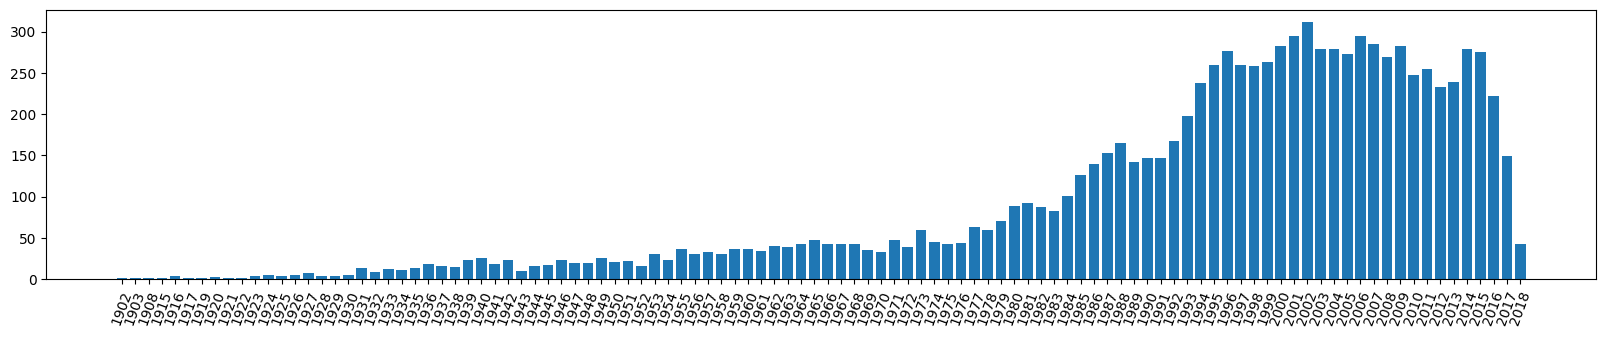

In [4]:
# number of movies released per year
year_data = sqldf(''' 
    SELECT * FROM movies_data ORDER BY year
''')

# movies distribution per year
movie_year = sqldf('''  
    SELECT year, COUNT(year) AS freq FROM movies_data
    GROUP BY year
''')

# distribution plot
fig1, ax1 = plt.subplots()
fig1.set_size_inches(20, 3.5)
years = movie_year['year'].values
counts = movie_year['freq'].values
ax1.bar(years, counts)
plt.xticks(years, rotation = 70)
plt.show()

Regarding the genres of each film, the following figure represents the distribution of genres across all films. It should be noted that Drama and Comedy are the most viewed genres.

<Axes: >

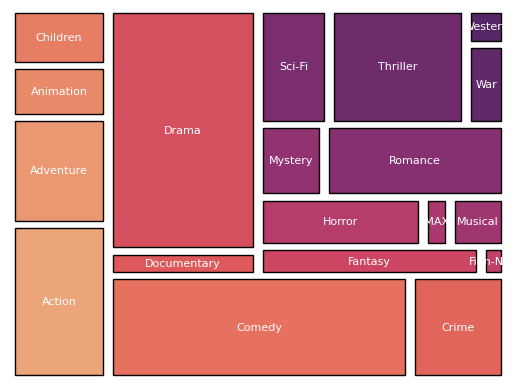

In [5]:
import squarify
# movies distribution per genre
freqs = [] # frequency
for gi in auxg: # itereate over genres
    auxF = sqldf(f''' 
        SELECT * FROM movies_data WHERE [{gi}]=1
    ''')
    freqs.append(len(auxF))

# Treemap
plt.axis("off")
squarify.plot(sizes=freqs, label=auxg,
                text_kwargs = {'fontsize': 8, 'color': 'white'},
                pad=0.2, ec= 'black',
                color = sb.color_palette("flare", len(freqs)))

Below are highest average rating drama films of recent years, including films such as The Shawshank Redemption, Fight Club and Goodfellas:

In [6]:
# top drama movies in the last years, considering movies with at least 15 reviews
top_drama = sqldf('''  
    SELECT movieId, title, year, avg_rating FROM movies_data
    WHERE ratings >= 15 AND Drama=1 AND year>=1990
    ORDER BY avg_rating DESC
''')
top_drama.head(10)

,movieId,title,year,avg_rating
0,318,"Shawshank Redemption, The",1994,4.429022
1,475,In the Name of the Father,1993,4.300000
2,2959,Fight Club,1999,4.272936
3,48516,"Departed, The",2006,4.252336
4,1213,Goodfellas,1990,4.250000
5,1719,"Sweet Hereafter, The",1997,4.250000
6,58559,"Dark Knight, The",2008,4.238255
7,527,Schindler's List,1993,4.225000
8,1245,Miller's Crossing,1990,4.225000
9,3275,"Boondock Saints, The",2000,4.220930


Taking the most popular Drama movie (The Shawshank Redemption wiith movideId 318) as an example, we can study the most watched genres by users who have watched this movie. The following figure shows the distribution of genres watched by these users, note that Drama remains the most watched genre, because users watch movies of similar genres.

<Axes: >

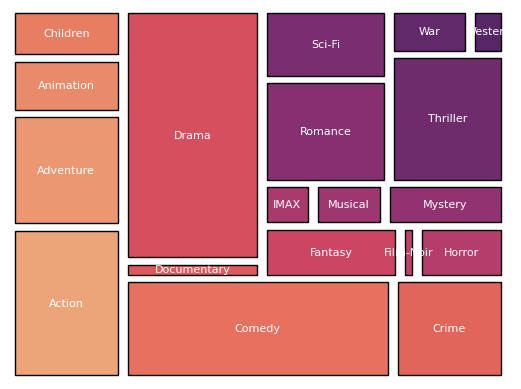

In [7]:
# distribution of genres wathced by users who liked Shawshank Redemption, The (moviedId 318)
# viewers of selected movie
viewers_data = sqldf(''' 
    WITH T2 AS
        (WITH T AS
            (SELECT userId FROM ratings_data
            WHERE  movieId=318)
        SELECT * FROM T LEFT JOIN ratings_data
            on T.userId=ratings_data.userId)
    SELECT userId, movieId, rating from T2 WHERE movieId!=318
''')

# information of movies watched by users and reviews with at least 4.0
bests = sqldf(''' 
    WITH T AS (
        SELECT DISTINCT movieId FROM viewers_data
        WHERE rating>=5.0
        ORDER BY movieId
              )
    SELECT * FROM T LEFT JOIN movies_data
    ON T.movieId=movies_data.movieId
''')
bests = bests.drop(['movieId'], axis=1)

# genres count
freqs = []
for gi in auxg:
    auxF = sqldf(f''' 
        SELECT * FROM bests WHERE [{gi}]=1
    ''')
    freqs.append(len(auxF))

# Treemap
plt.axis("off")
squarify.plot(sizes=freqs, label=auxg,
                text_kwargs = {'fontsize': 8, 'color': 'white'},
                pad=0.2, ec= 'black',
                color = sb.color_palette("flare", len(freqs)))

## 2. Model implementation.
The implementation of the model requires training the k-Means algorithm on the characteristics of the films and calculating the collaborative filtering matrices of each cluster. This process is performed once and both the trained model and the set of matrices are stored for later use to make personalized recommendations.

Regarding the training of the k-Means algorithm, a training dataset is first constructed with the features of each movie, including the year of publication, number of ratings, average rating, and genres. Next, a pipeline is implemented that includes a Column Transformer and the k-Means algorithm. The column transformer class transforms each column depending on whether the attribute is numeric or nominal. Finally, the k-Means algorithm is trained on the movie features and the model is written to a pickle file.

In [8]:
# loading libraries
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.cluster import KMeans
import pickle


# generation of training data
train_data = sqldf(''' 
    SELECT movieId, year, ratings, avg_rating, Action, Adventure, Animation,
       Children, Comedy, Crime, Documentary, Drama, Fantasy,
       [Film-Noir], Horror, IMAX, Musical, Mystery, Romance,
       [Sci-Fi], Thriller, War, Western FROM movies_data    
''')

# data procesing
train_data = train_data.dropna()
Xs = train_data.drop(['movieId'], axis=1)

# procesing of numerical features (year, ratings, avg_rating)
numeric_features = ['year', 'ratings', 'avg_rating']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# procesing of categorical features (no transformation)
categorical_features = ['Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western']
categorical_transformer = FunctionTransformer() # transformacion identidad

# preprocesador de ambos tipos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# k-means algorithm
kmeans = KMeans(n_clusters=5, random_state=1, n_init="auto")

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('k-means', kmeans)])
model.fit(Xs)

# saving model
with open('model_k_means.pkl','wb') as f:
    pickle.dump(model,f)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'ratings',
                                                   'avg_rating']),
                                                 ('cat', FunctionTransformer(),
                                                  ['Action', 'Adventure',
                                                   'Animation', 'Children',
                                                   'Comedy', 'Crime',
                                                   'Documentary', 'Drama',
                                                   'Fantasy', 'Film-Noir',
                                                   'Horror', 'IMAX', 'Musical',
                                                   'Mystery', 'Romance',
                                                   'Sci-Fi', 'Thriller', 'War',
                                                   'Western'])])),
                ('k-means', KMeans(n_clusters=5, random_state=1))])

The following table presents the top 10 rated movies found in each cluster after training the k-Mean algorithm considering 5 clusters:

In [9]:
# prediction of the class of each movie
preds = model.predict(Xs)

# table with the classification of each movie
movies_class = pd.DataFrame({'movieId':train_data['movieId'].values,
                             'class': preds})

# information join
auxC = sqldf(''' 
    SELECT movies_class.movieId, title, year, ratings, avg_rating, class FROM movies_class LEFT JOIN movies_data
    ON movies_class.movieId=movies_data.movieId
''')

# top 10 movies on each cluster, considering at least 20 reviews
aux_dic = {'ranking': [i for i in range(1,11)]}
for ci in range(5): # tenemos 5 clusters
    aux_top = sqldf(f''' 
        SELECT * FROM auxC
        WHERE class={ci} AND ratings>=20
        ORDER BY avg_rating DESC
    ''')
    aux_dic[f'class_{ci}'] = list(aux_top['title'].values[0:10])
data_tops = pd.DataFrame(aux_dic)
data_tops

,ranking,class_0,class_1,class_2,class_3,class_4
0,1,In the Name of the Father,"Streetcar Named Desire, A","Shawshank Redemption, The",Old Boy,Buffy the Vampire Slayer
1,2,Hoop Dreams,Sunset Blvd. (a.k.a. Sunset Boulevard),"Godfather, The","Grand Day Out with Wallace and Gromit, A",Joe Dirt
2,3,Logan,"Philadelphia Story, The",Fight Club,Howl's Moving Castle (Hauru no ugoku shiro),Toys
3,4,Miller's Crossing,Lawrence of Arabia,Dr. Strangelove or: How I Learned to Stop Worr...,"Femme Nikita, La (Nikita)",Angels in the Outfield
4,5,"Boondock Saints, The",Harold and Maude,Rear Window,Kiss Kiss Bang Bang,The Scorpion King
5,6,"Boot, Das (Boat, The)",Cool Hand Luke,"Godfather: Part II, The",Laputa: Castle in the Sky (Tenkû no shiro Rapy...,Scary Movie 3
6,7,Raging Bull,Notorious,"Departed, The",Evil Dead II (Dead by Dawn),Superman III
7,8,Glory,"Manchurian Candidate, The",Goodfellas,Army of Darkness,Richie Rich
8,9,Cinema Paradiso (Nuovo cinema Paradiso),All About Eve,Casablanca,"Road Warrior, The (Mad Max 2)",I Know What You Did Last Summer
9,10,In Bruges,"Third Man, The","Dark Knight, The","Cabin in the Woods, The",Inspector Gadget


Regarding the calculation of the Collaborative Filtering matrices, for each cluster a movie-user matrix is ​​calculated considering only the movies of the cluster and the users who have seen them. Unlike the conventional approach in which the user-movies matrix is ​​calculated for the entire dataset, in this case the complexity of the process is reduced, since the calculated matrices are significantly smaller, facilitating the implementation of the Recommendation System.

In [10]:
# calculation of the user-movie rating matrix of each movie cluster
frames = []
for ci in [0,1,2,3,4]: # iterate over each cluster
    # movies info of current cluster
    auxJ = sqldf(f''' 
        WITH T1 AS (
            SELECT movieId FROM movies_class WHERE class={ci}
        )
        SELECT userId, T1.movieId, rating FROM T1 LEFT JOIN ratings_data
        ON T1.movieId=ratings_data.movieId ORDER BY userId, T1.movieId
    ''')

    # dataframe creation
    u_ids = np.unique(auxJ['userId'].values) # number of users
    m_ids = np.unique(auxJ['movieId'].values) # number of movies
    aux_dic = {}
    for mi in m_ids:
        aux_dic[f'{mi}'] = [0.0]*len(u_ids)
    data_ci = pd.DataFrame(index=u_ids, data=aux_dic)

    # writing of each users ratings
    for ui in u_ids:
        data_ui = sqldf(f''' 
            SELECT movieId, rating FROM auxJ
            WHERE userId={ui}            
        ''')
        for mi, ri in zip(data_ui['movieId'].values, data_ui['rating'].values):
            data_ci.at[ui, f'{mi}'] = ri
    
    # dataframe wirting
    data_ci.to_csv(f'cf_matrices/cf_matrix_{ci}.csv', index=True)

The recommendation system is implemented by leveraging both the trained k-Means model and the previously calculated collaborative filtering matrices. The implementation of the model is shown below, which considers the following points:
1. The recommendation system loads the pre-trained model and the collaborative filtering matrices. Thus, we ensure that the loading does not require retraining the kmeans algorithm or recalculating the user-movies matrices, which would result in an inefficient process.
2. The model predictions are implemented in the recommend function, which considers the following points:
    - The function receives a dictionary with a new user's ratings as inputs and calculates the centroid of his highest rated movies.
    - The k-Means algorithm is used to classify the centroid of the movies in a cluster.
    - The user-movie matrix of this cluster is used to apply the Collaborative Filtering technique, which consists of finding the most similar users based on their movie ratings and predicting a rating vector based on these users' ratings.
    


In [16]:
# loading libraries
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.cluster import KMeans
import pickle
import pandas as pd
from pandasql import sqldf
from sklearn.neighbors import NearestNeighbors

class RecomenderSystem:
    def __init__(self, k=5):
        # load model
        with open('model_k_means.pkl', 'rb') as f:
            self.model = pickle.load(f)
        
        # load cf matrices
        self.cf_matrices = []
        for i in range(5):
            self.cf_matrices.append(pd.read_csv(f'cf_matrices/cf_matrix_{i}.csv', index_col=0))

        # k value for k Nearest Neighbor
        self.k = k

    
    def recomend(self, ratings):
        # read movies dataframe
        movies_data = pd.read_csv('Data/movies_full_data.csv')
        
        # identify top movies and their ids
        movies = []
        ids = []
        for ki in list(ratings.keys()):        
            if ratings[ki]>=4.0: # at leats 4.0 rating
                movies.append(ki)
                aux_ids = sqldf(f'''
                    SELECT movieId FROM movies_data
                    WHERE title="{ki}"
                ''')
                ids.append(aux_ids.values[0,0])

        # extract vector of each movie
        vectors = movies_data[movies_data['movieId'].isin(ids)]
        vectors = vectors.drop(['movieId', 'title'], axis=1)

        # centroid calculation
        cent = np.mean(vectors.values, axis=0)
        Fcent = pd.DataFrame(data=[cent], columns=('year','ratings','avg_rating','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','IMAX','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'))
        
        # k-means classification
        ci = self.model.predict(Fcent)[0]
        
        # identification of the movies that actually belongs to this cluster
        cluster_movies = list(self.cf_matrices[ci].columns)
        auxb = [f'{mi}' in cluster_movies for mi in ids]
        movies = np.array(movies)[auxb]
        ids = np.array(ids)[auxb]
        
        # user-movies vector
        user_vector = Fcent = pd.DataFrame(data=[[0.0]*len(cluster_movies)], columns=tuple(cluster_movies))
        rs = [ratings[mi] for mi in movies]
        for id, ri in zip(ids, rs):
            user_vector.at[0, f'{id}'] = ri
        
        # get the k nearest users in Collaboprative Filtering matrix
        Xs = self.cf_matrices[ci].values # users vectors
        nn = NearestNeighbors(n_neighbors=self.k).fit(Xs)
        _, indices = nn.kneighbors(user_vector.values)
        
        # calculate the mean ratings considering only non zero values
        aux_p = Xs[indices[0]]
        pred_ratings = []
        for pi in range(aux_p.shape[1]):
            aux_r = aux_p[:,pi]
            non_zeros = np.sum(aux_r!=0.0)
            mean = np.sum(aux_r)/np.max([non_zeros, 1]) # prevent division by zero
            pred_ratings.append(mean)
        
        # identify the top recomendations, considering non-zero ratings
        auxF = pd.DataFrame(data = [pred_ratings], columns=tuple(cluster_movies))
        top_movieIds = []
        top_ratings = []
        for id in cluster_movies: # iterate over movies in cluster
            ri = auxF[id].values[0]
            if ri != 0: # non zero ratings
                top_movieIds.append(id)
                top_ratings.append(ri)
        pred_movies_ratings = pd.DataFrame({'movieId': top_movieIds,
                                            'rating': top_ratings})
        preds = sqldf(''' 
            SELECT pred_movies_ratings.movieId, movies_data.title, pred_movies_ratings.rating FROM pred_movies_ratings
            LEFT JOIN movies_data on pred_movies_ratings.movieId=movies_data.movieId ORDER BY pred_movies_ratings.rating DESC
        ''')
        print(preds)

## 3. Recomendation examples.
Below are some examples of the recommendation system. Note that it receives as input a dictionary of movie ratings of a new user. The system returns a set of recommendations and makes a prediction of the rating that the user would assign to each recommendation, in this way an informed decision can be made about which movies to recommend.

In [53]:
test = RecomenderSystem()
ratings = {'Godfather, The': 4.5, 'The Island':4.5, 'Rocky II':4.0, 'Batman: Gotham Knight':4.5}
test.recomend((ratings))

  movieId                title  rating
0    3671      Blazing Saddles    4.00
1    6502        28 Days Later    4.00
2   33794        Batman Begins    3.50
3    2005         Goonies, The    2.00
4    4226              Memento    2.00
5    1302      Field of Dreams    1.25
6     527     Schindler's List    0.50
7    3949  Requiem for a Dream    0.50
8   68954                   Up    0.50
